# **Imports**

In [ ]:
!pip install transformers
!pip install pyvis
!pip install networkx
!pip install spacy transformers
!pip install wikipedia

# !python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=10ac3b6a204260469b06d60a5262d3c2ce4107d00c467482411345b6ef8b0bd6
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import DistilBertTokenizer
import re
import nltk
from nltk.tokenize import sent_tokenize
from pyvis.network import Network
import networkx as nx
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM
import networkx as nx
from transformers import pipeline, AutoTokenizer, AutoModelForQuestionAnswering
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import spacy
import wikipedia
import torch
import warnings
warnings.filterwarnings("ignore")



In [ ]:
# Download the necessary NLTK resources (run this only once)
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")



[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Text to Entity Extraction**

## **Load the model**

In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model and tokenizer
ent_tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
ent_model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

# Move model to GPU if available
ent_model.to(device)

# Create the pipeline with the model and tokenizer
triplet_extractor = pipeline('text2text-generation', model=ent_model, tokenizer=ent_tokenizer, device=0 if torch.cuda.is_available() else -1)



tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/344 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

## **Load the Input text**

In [ ]:
page = wikipedia.page('The French Revolution')
full_text = page.content

# Print the full text
print(full_text)


The French Revolution was a period of political and societal change in France that began with the Estates General of 1789, and ended with the coup of 18 Brumaire in November 1799 and the formation of the French Consulate. Many of its ideas are considered fundamental principles of liberal democracy, while its values and institutions remain central to modern French political discourse.
Its causes are generally agreed to be a combination of social, political, and economic factors, which the Ancien Régime proved unable to manage. A financial crisis and widespread social distress led in May 1789 to the convocation of the Estates General, which was converted into a National Assembly in June. The Storming of the Bastille on 14 July led to a series of radical measures by the Assembly, among them the abolition of feudalism, state control over the Catholic Church in France, and a declaration of rights.
The next three years were dominated by the struggle for political control, exacerbated by econ

In [ ]:
# short_text = "John, a software engineer, works at Google and lives in San Francisco."


## **Split the Text**

In [ ]:
def clean_text(text):
    # Remove citation markers like [6], [7], etc.
    text = re.sub(r'$$\d+$$', '', text)

    # Remove section headers like "== Causes =="
    text = re.sub(r'==\s*[^=]+\s*==', '', text)

    # Remove special characters except full stops
    text = re.sub(r'[^\w\s.]', '', text)

    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [ ]:
def split_text_into_sentences(text):
    return sent_tokenize(text)

def split_text_into_batches(sentences, batch_size):
    for i in range(0, len(sentences), batch_size):
        yield sentences[i:i + batch_size]


def split_text_into_chunks(cleaned_text, batch_size=10):
  # Split the full text into sentences
  sentences = split_text_into_sentences(cleaned_text)

  # Specify batch size for processing sentences
  batch_size = 10

  # Store all processed sentences in a list
  all_sentences = []

  # Iterate over batches of sentences
  for batch in split_text_into_batches(sentences, batch_size):
      for sentence in batch:
          all_sentences.append(sentence)  # Store each sentence in the list

  return all_sentences


In [ ]:
# split the text
cleaned_text = clean_text(full_text)
split_text = split_text_into_chunks(cleaned_text)

print(len(split_text))

422


In [ ]:
# Print each chunk
for i, chunk in enumerate(split_text, 1):
    print(f"Chunk {i}:\n{chunk}\n")


Chunk 1:
The French Revolution was a period of political and societal change in France that began with the Estates General of 1789 and ended with the coup of 18 Brumaire in November 1799 and the formation of the French Consulate.

Chunk 2:
Many of its ideas are considered fundamental principles of liberal democracy while its values and institutions remain central to modern French political discourse.

Chunk 3:
Its causes are generally agreed to be a combination of social political and economic factors which the Ancien Régime proved unable to manage.

Chunk 4:
A financial crisis and widespread social distress led in May 1789 to the convocation of the Estates General which was converted into a National Assembly in June.

Chunk 5:
The Storming of the Bastille on 14 July led to a series of radical measures by the Assembly among them the abolition of feudalism state control over the Catholic Church in France and a declaration of rights.

Chunk 6:
The next three years were dominated by the s

## **Extract the Entities**

In [ ]:
# Function to parse the generated text and extract the triplets
def extract_triplets(text):
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
    return triplets


In [ ]:
# Process each chunk
extracted_triplets = []
for idx, chunk in enumerate(split_text, 1):
    extracted_text = triplet_extractor.tokenizer.batch_decode(
        [triplet_extractor(chunk, return_tensors=True, return_text=False)[0]["generated_token_ids"]]
    )
    extracted_triplets_chunk = extract_triplets(extracted_text[0])
    extracted_triplets.extend(extracted_triplets_chunk)


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
print(len(extracted_triplets))

635


In [ ]:
print(extracted_triplets)

[{'head': 'French Revolution', 'type': 'has part', 'tail': 'Estates General of 1789'}, {'head': 'French Revolution', 'type': 'has part', 'tail': '18 Brumaire'}, {'head': 'French Revolution', 'type': 'has part', 'tail': 'French Consulate'}, {'head': 'Estates General of 1789', 'type': 'part of', 'tail': 'French Revolution'}, {'head': '18 Brumaire', 'type': 'part of', 'tail': 'French Revolution'}, {'head': 'French Consulate', 'type': 'part of', 'tail': 'French Revolution'}, {'head': 'liberal democracy', 'type': 'instance of', 'tail': 'values'}, {'head': 'Ancien Régime', 'type': 'instance of', 'tail': 'social political'}, {'head': 'Estates General', 'type': 'replaced by', 'tail': 'National Assembly'}, {'head': 'National Assembly', 'type': 'replaces', 'tail': 'Estates General'}, {'head': 'Storming of the Bastille', 'type': 'country', 'tail': 'France'}, {'head': 'Catholic Church', 'type': 'country', 'tail': 'France'}, {'head': 'struggle for political control', 'type': 'has cause', 'tail': 'e

# **Graph Creation**

In [ ]:
data = extracted_triplets.copy()


## **Create the Graph**

In [ ]:
# NetworkX graph
G = nx.DiGraph()

# Add nodes and edges to the graph
for entry in data:
    head = entry['head']
    tail = entry['tail']
    relation = entry['type']

    G.add_node(head)
    G.add_node(tail)

    G.add_edge(head, tail, relation=relation)

G

## **Visulize the Graph**

In [ ]:
# Pyvis Network for visulization
net = Network(notebook=True, filter_menu=True, select_menu=True)

head_color = '#81C784'   # Light Green
tail_color = '#FFB74D'   # Light Salmon
edge_color = '#1E88E5'    # Blue
font_color = '#212121'     # Black

# Add nodes and edges to Pyvis network
for node in G.nodes():
    color = head_color if any(G.successors(node)) else tail_color
    net.add_node(node, label=node, color=color, title=node)

for edge in G.edges(data=True):
    head, tail, attrs = edge
    relation = attrs['relation']
    net.add_edge(
        head,
        tail,
        title=relation,
        label=relation,
        arrows='to',
        color=edge_color,
        dashes=False
    )

net.force_atlas_2based()

# Show the graph directly in the notebook
net.show("Graph.html")


Graph.html


# **RAG Model**

In [ ]:
device_id = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Loading multiple models to get response**

In [ ]:
qa_pipelines = {
    'transformer_default': pipeline("question-answering", device=device_id, max_answer_len=2048)
}


No model was supplied, defaulted to distilbert/distilbert-base-cased-distilled-squad and revision 564e9b5 (https://huggingface.co/distilbert/distilbert-base-cased-distilled-squad).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## **Extract Entities from the Question**

In [ ]:
def extract_entities_from_query(query):
    doc = nlp(query)

    # Extract named entities
    entities = [ent.text for ent in doc.ents]

    # Extract nouns
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']

    # Combine entities and nouns
    all_entities_and_nouns = entities + nouns

    return all_entities_and_nouns



## **Extract subgraph**

In [ ]:
def tokenize_and_stem(text):
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    tokens = word_tokenize(text.lower())
    filtered_tokens = [stemmer.stem(word) for word in tokens if word.isalnum() and word not in stop_words]
    return filtered_tokens

def fuzzy_match(entity_tokens, node_tokens):
    entity_set = set(entity_tokens)
    node_set = set(node_tokens)
    intersection = entity_set.intersection(node_set)
    return len(intersection) / max(len(entity_set), 1)

def retrieve_subgraph(query, graph, max_depth=4, match_threshold=0.4):
    """Retrieve a subgraph relevant to the query."""
    entities = extract_entities_from_query(query)
    subgraph = nx.MultiDiGraph()

    for entity in entities:
        entity_tokens = tokenize_and_stem(entity)
        for node in graph.nodes:
            node_tokens = tokenize_and_stem(node)
            match_score = fuzzy_match(entity_tokens, node_tokens)
            if match_score >= match_threshold:
                for _, neighbor in nx.bfs_edges(graph, source=node, depth_limit=max_depth):
                    try:
                        relation = graph[node][neighbor][0].get('relation', 'related_to')
                        subgraph.add_edge(node, neighbor, relation=relation)
                    except (KeyError, IndexError):
                        subgraph.add_edge(node, neighbor, relation='related_to')

    return subgraph


## **Subgraph in Textual format**

In [ ]:
def convert_subgraph_to_text(subgraph):
    triples = []
    for u, v, data in subgraph.edges(data=True):
        relation = data.get('relation', 'related_to')
        triples.append({'head': u, 'type': relation, 'tail': v})

    # Convert the list of triples to a formatted string
    formatted_triples = [f"{{'head': '{triple['head']}', 'type': '{triple['type']}', 'tail': '{triple['tail']}'}}" for triple in triples]
    return "[\n" + ",\n".join(formatted_triples) + "\n]"


## **Generate Response**

In [ ]:
def generate_response(query, graph):
    subgraph = retrieve_subgraph(query, graph)

    if not subgraph.nodes:
        combined_list = []
        response = {
            'subgraph':  nx.MultiDiGraph(),
            'subgraph_text': None,
            'responses':
                {'None':
                     {'answer': 'Sorry, I could not find any relevant information.'
                     }
                }
                    }

        return combined_list, response

    subgraph_text = convert_subgraph_to_text(subgraph)

    responses = {name: pipeline({'question': query, 'context': subgraph_text}) for name, pipeline in qa_pipelines.items()}

    combined_list = list(responses.values())

    response = {
        "subgraph": subgraph,
        "subgraph_text": subgraph_text,
        "responses": responses
    }

    return combined_list, response


## **Visulize subgraph**

In [ ]:
def visualize_subgraph(subgraph, query):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray")
    edge_labels = {(u, v): data.get('relation', 'related_to') for u, v, data in subgraph.edges(data=True)}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color="red")
    plt.title(f"Subgraph for query: {query}")
    plt.show()



## **Enhance the Response**

In [ ]:
# Initialize the model
enhance_pipe = pipeline("text-generation", model="Qwen/Qwen2.5-0.5B-Instruct", max_length=1024, device = device_id)


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

In [ ]:
def enhance_answer(query, answer):
    sys_prompt = "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."
    user_prompt = f"""Given the user input: '{{ "Query": "{query}", "Answer": "{answer}" }}', enhance the answer based on the provided Query and Answer. Provide a direct and descriptive response without mentioning that you are enhancing the answer. Avoid any unnecessary explanations or notes at the end."""

    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": user_prompt}
    ]
    enhanced_response = enhance_pipe(messages)
    return enhanced_response[0]['generated_text'][-1]['content']


## **Set your Questions**

In [ ]:
queries = [
    "When did the French Revolution start?",
    "Who led the coup of 18 Brumaire in November 1799?",
    "What was the name of the assembly that replaced the monarchy in September 1792?",
    "What was the name of the radical club that played a significant role in the Revolution?",
    "What was the main cause of French Revolution?"
]

## **Run the RAG Model**

### **Simple Run: Without showing subgraphs. Only showing Answers**

In [ ]:
print('Main Graph details:', G)
for query in queries:
    combined_list, response = generate_response(query, G)
    subgraph = response.get('subgraph', nx.MultiDiGraph())
    subgraph_text = response.get('subgraph_text', '')

    # Print the query and subgraph details
    print(f"\n+++++++++++++++ Query: {query} ++++++++")
#     print("Subgraph Details:")
#     print(subgraph)
#     print(subgraph_text)
    print()

    # Handle the case where subgraph_text is None
    if subgraph_text is None:
        print(f"*** Answer: {response['responses']['None']['answer']} ***")
        print()
        continue

    # Print responses from each pipeline
    if 'responses' in response:
        for name, answer in response['responses'].items():
            clean_ans = clean_text(answer['answer'])
            print(f"-> Answer: {clean_ans}")

            # Enhance the answer
            enhanced_answer = enhance_answer(query, clean_ans)
            print(f"-> Enhanced Answer: {enhanced_answer}")
            print()
    else:
        print("*** No responses available. ***")
        print()

    print()


Main Graph details: DiGraph with 624 nodes and 585 edges

+++++++++++++++ Query: When did the French Revolution start? ++++++++

-> Answer: 20 April 1792
-> Enhanced Answer: The French Revolution began on April 17, 1789.



+++++++++++++++ Query: Who led the coup of 18 Brumaire in November 1799? ++++++++

-> Answer: Napoleon Bonaparte
-> Enhanced Answer: The person who led the coup of 18 Brumaire was Napoleon Bonaparte. He seized power in France in November 1799 and became its dictator for three years until his death in 1821.



+++++++++++++++ Query: What was the name of the assembly that replaced the monarchy in September 1792? ++++++++

-> Answer: National Assembly
-> Enhanced Answer: The National Assembly replaced the monarchy in September 1792.



+++++++++++++++ Query: What was the name of the radical club that played a significant role in the Revolution? ++++++++

-> Answer: Jacobin Club
-> Enhanced Answer: The Jacobin Club played a crucial role in the revolution, marking the be

### **Detailed Run: With showing Answers and Subgraphs**

Main Graph details: DiGraph with 624 nodes and 585 edges

+++++++++++++++ Query: When did the French Revolution start? ++++++++++++++++++++++

-> Answer: 20 April 1792
-> Enhanced Answer: The French Revolution began on April 17, 1789.

****Subgraph Visualization ***


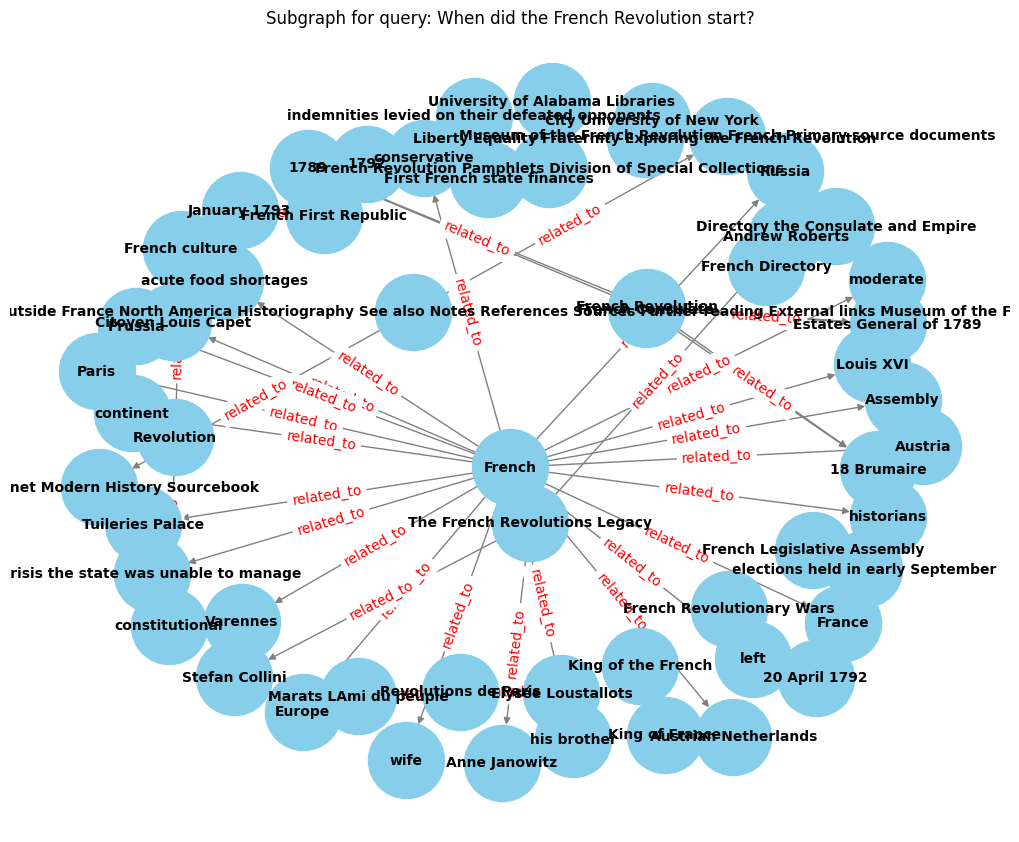


*** Subgraph Details: ***
MultiDiGraph with 57 nodes and 47 edges
[
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '18 Brumaire'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'French Consulate'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '1789'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': 'French Revolution'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': '18 Brumaire'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': '1789'},
{'head': 'French Revolutionary Wars', 'type': 'related_to', 'tail': '20 April 1792'},
{'head': 'French First Republic', 'type': 'related_to', 'tail': 'January 1793'},
{'head': 'French First Republic', 'type': 'related_to', 'tail': '1792'},
{'head': 'French', 'type': 'related_to', 'tail': 'Paris'},
{'head'

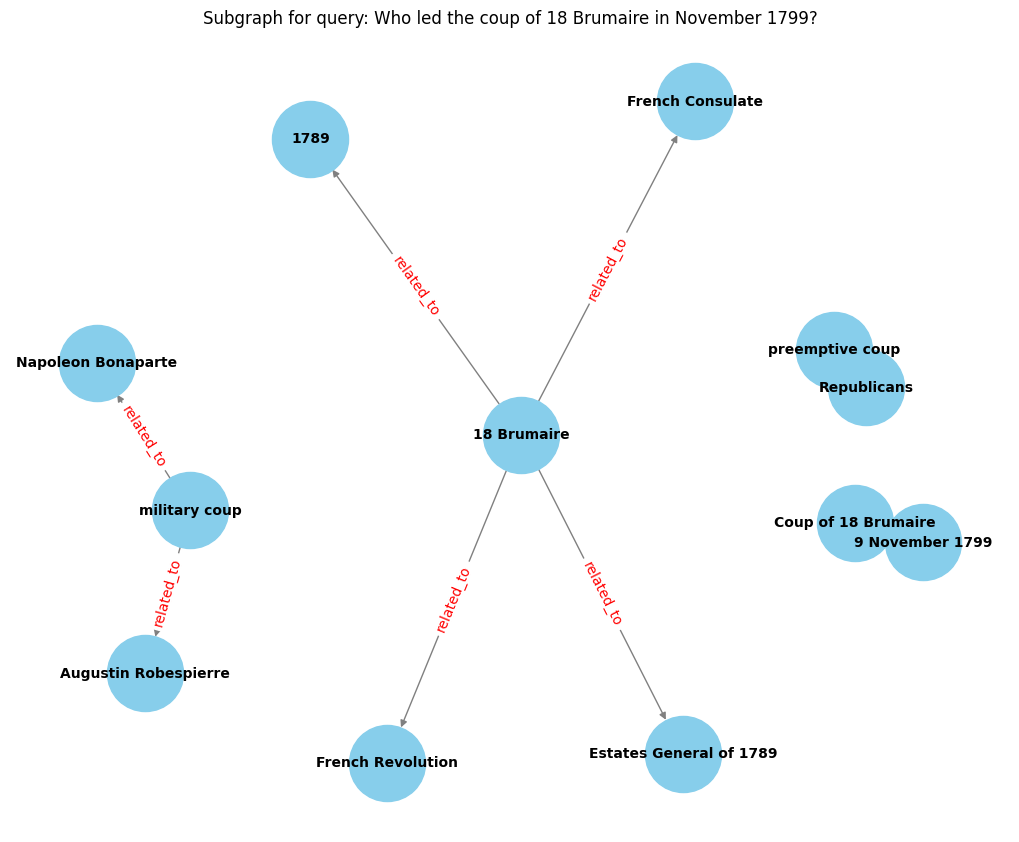


*** Subgraph Details: ***
MultiDiGraph with 12 nodes and 9 edges
[
{'head': '18 Brumaire', 'type': 'related_to', 'tail': 'French Revolution'},
{'head': '18 Brumaire', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': '18 Brumaire', 'type': 'related_to', 'tail': 'French Consulate'},
{'head': '18 Brumaire', 'type': 'related_to', 'tail': '1789'},
{'head': 'Coup of 18 Brumaire', 'type': 'related_to', 'tail': '9 November 1799'},
{'head': 'Coup of 18 Brumaire', 'type': 'related_to', 'tail': '9 November 1799'},
{'head': 'military coup', 'type': 'related_to', 'tail': 'Napoleon Bonaparte'},
{'head': 'military coup', 'type': 'related_to', 'tail': 'Augustin Robespierre'},
{'head': 'preemptive coup', 'type': 'related_to', 'tail': 'Republicans'}
]

+++++++++++++++ Query: What was the name of the assembly that replaced the monarchy in September 1792? ++++++++++++++++++++++

-> Answer: National Assembly
-> Enhanced Answer: The National Assembly was the name of the assembly that repl

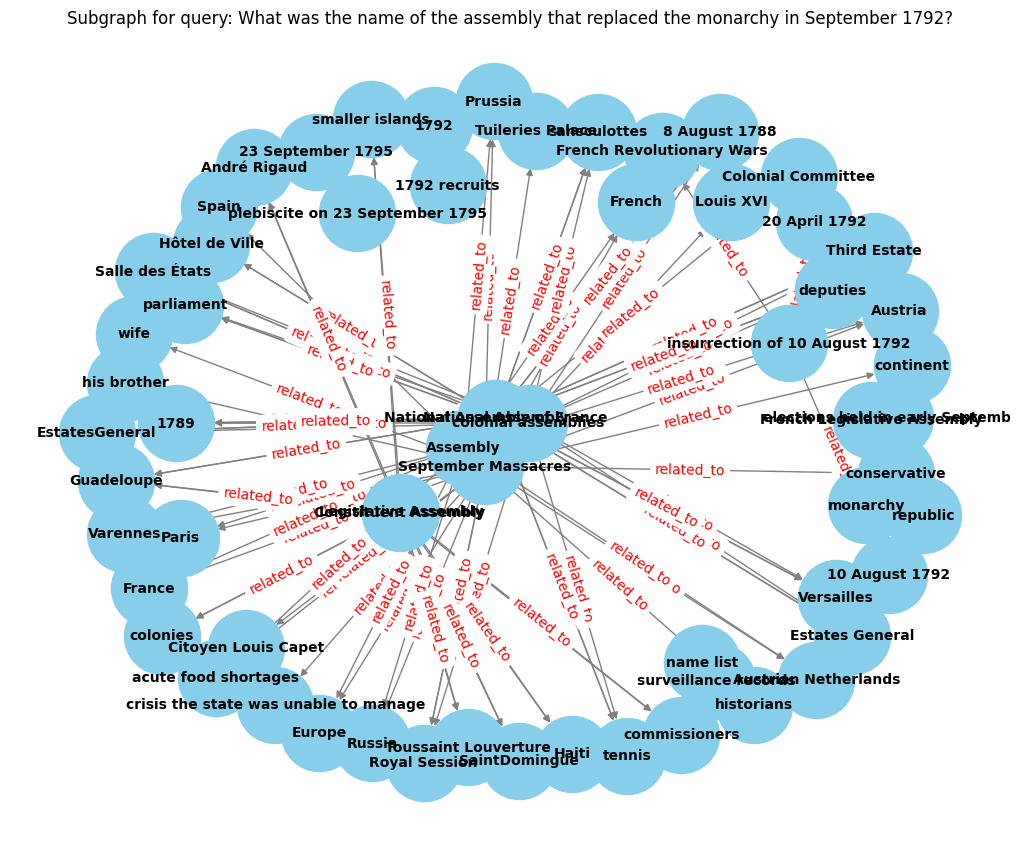


*** Subgraph Details: ***
MultiDiGraph with 63 nodes and 105 edges
[
{'head': 'insurrection of 10 August 1792', 'type': 'related_to', 'tail': 'French Revolutionary Wars'},
{'head': 'insurrection of 10 August 1792', 'type': 'related_to', 'tail': '10 August 1792'},
{'head': 'insurrection of 10 August 1792', 'type': 'related_to', 'tail': '20 April 1792'},
{'head': 'elections held in early September', 'type': 'related_to', 'tail': 'French Legislative Assembly'},
{'head': 'French Legislative Assembly', 'type': 'related_to', 'tail': 'elections held in early September'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 'Paris'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 'French'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 'Europe'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 'Varennes'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 'France'},
{'head': 'September Massacres', 'type': 'related_to', 'tail': 

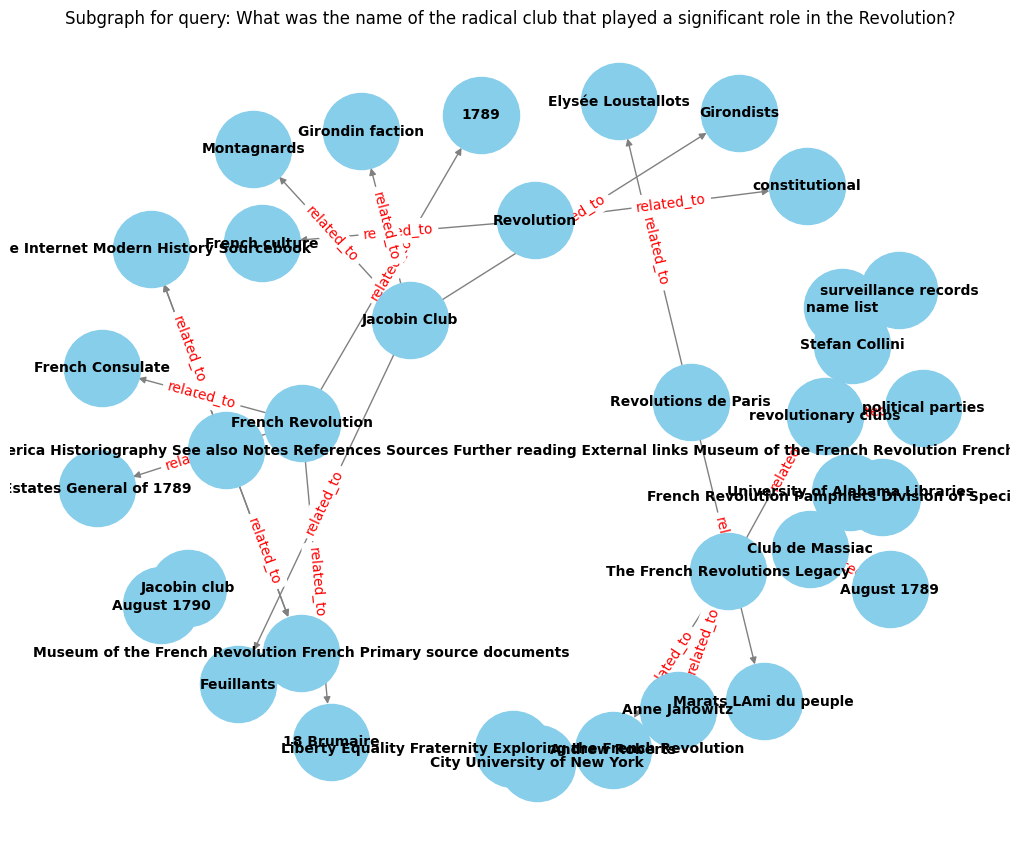


*** Subgraph Details: ***
MultiDiGraph with 35 nodes and 25 edges
[
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '18 Brumaire'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'French Consulate'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '1789'},
{'head': 'Revolution', 'type': 'related_to', 'tail': 'French culture'},
{'head': 'Revolution', 'type': 'related_to', 'tail': 'constitutional'},
{'head': 'Revolutions de Paris', 'type': 'related_to', 'tail': 'Marats LAmi du peuple'},
{'head': 'Revolutions de Paris', 'type': 'related_to', 'tail': 'Elysée Loustallots'},
{'head': 'Role of women Prominent women Economic policies Impact France Europe outside France North America Historiography See also Notes References Sources Further reading External links Museum of the French Revolution French Primary source documents', 'type': 'related_to', 'tail': 'The Internet 

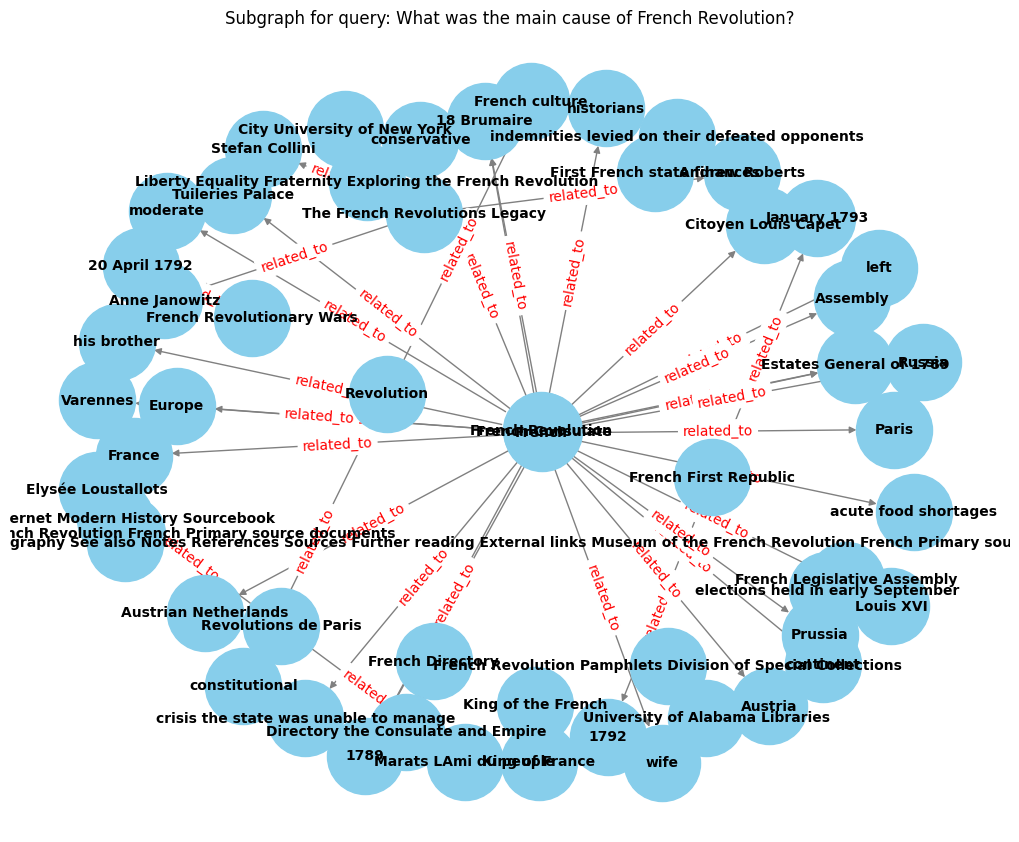


*** Subgraph Details: ***
MultiDiGraph with 57 nodes and 47 edges
[
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '18 Brumaire'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': 'French Consulate'},
{'head': 'French Revolution', 'type': 'related_to', 'tail': '1789'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': 'French Revolution'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': 'Estates General of 1789'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': '18 Brumaire'},
{'head': 'French Consulate', 'type': 'related_to', 'tail': '1789'},
{'head': 'French Revolutionary Wars', 'type': 'related_to', 'tail': '20 April 1792'},
{'head': 'French First Republic', 'type': 'related_to', 'tail': 'January 1793'},
{'head': 'French First Republic', 'type': 'related_to', 'tail': '1792'},
{'head': 'French', 'type': 'related_to', 'tail': 'Paris'},
{'head'

In [ ]:
print('Main Graph details:', G)
for query in queries:
    combined_list, response = generate_response(query, G)
    subgraph = response.get('subgraph', nx.MultiDiGraph())
    subgraph_text = response.get('subgraph_text', '')

    # Print the query and subgraph details
    print(f"\n+++++++++++++++ Query: {query} ++++++++++++++++++++++")
    print()

    # Handle the case where subgraph_text is None
    if subgraph_text is None:
        print(f"*** Answer: {response['responses']['None']['answer']} ***")
        print()
        continue

    # Print responses from each pipeline
    if 'responses' in response:
        for name, answer in response['responses'].items():
            clean_ans = clean_text(answer['answer'])
            print(f"-> Answer: {clean_ans}")

            # Enhance the answer
            enhanced_answer = enhance_answer(query, clean_ans)
            print(f"-> Enhanced Answer: {enhanced_answer}")
            print()
    else:
        print("*** No responses available. ***")
        print()

    # Visualize the subgraph
    print('****Subgraph Visualization ***')
    visualize_subgraph(subgraph, query)
    print()
    print("*** Subgraph Details: ***")
    print(subgraph)
    print(subgraph_text)
